## Because the vote fraction $f_{features}$ tends to drop heavily at high redshift and low surface brightness, we are likely incomplete in our sample of disks at these regions. We'll use the simulated FERENGI images to apply a multiplicitave correction to the number of disks we detect at a given z and $\mu$. 

In [2]:
%pylab inline
import matplotlib.gridspec as gridspec
from astropy.table import Table,Column
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
import os

from PIL import Image
import urllib, cStringIO
import random

#function for getting galaxy images
def get_image_from_url(url):

    file = cStringIO.StringIO(urllib.urlopen(url).read())
    img = Image.open(file)
    return img


mpl.rcParams['text.usetex']=True
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20 


Populating the interactive namespace from numpy and matplotlib


In [94]:
#The data: Contains 'best' vote fractions for the FERENGI data. See ferengi_debiased_votes.ipynb for details.
data=Table.read('../data/ferengi_debiased.fits')

In [62]:
#Dictionary to store f_features data for each galaxy, imaged at z=0.3 ('lo') and z = z ('hi')
#define edges of surface brightness bins
yedges=np.linspace(np.min(data['GZ_MU_I']),np.max(data['GZ_MU_I']),10)
yedges=[round(y,2) for y in yedges]

#define edges of simulated redshift bins
xedges=np.linspace(np.min(data['sim_redshift'])-.05,np.max(data['sim_redshift'])+.05,9)
xedges=[round(x,2) for x in xedges]

scatter_dct={}
for i in range(0,len(xedges)-1):
    for j in range(0,len(yedges)-1):
        scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'hi']=[]
        scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'lo']=[]
        scatter_dct[xedges[i],xedges[i+1],yedges[j],yedges[j+1],'subj_id']=[]

galaxies = set(data['sdss_id']) #set of 71 unique galaxies 

In [63]:
yedges

[17.83, 18.67, 19.51, 20.35, 21.18, 22.02, 22.86, 23.7, 24.54, 25.37]

In [64]:
#fill in scatter_dct
p_x = 't01_smooth_or_features_a02_features_or_disk_best_fraction'


for i,g in enumerate(galaxies):
    this_gal=(data['sdss_id']==g)
    evos = set(data[this_gal]['sim_evolution'])
    for e in evos:
        this_evo=(data[this_gal]['sim_evolution']==e)
        if len(set(data[this_gal][this_evo]['sim_redshift']))==8: #only want stuff where we have data down to 0.3
            p_at_3=(data[this_gal][this_evo]['sim_redshift']==.3)
            p_x_at_3 = data[this_gal][this_evo][p_at_3][p_x][0]#value of p_x at redshift 0.3
            for row in data[this_gal][this_evo]:
                for y in range(0,len(yedges)-1):
                    for x in range(0,len(xedges)-1):
                        if row['sim_redshift']>xedges[x] and row['sim_redshift'] < xedges[x+1] and row['GZ_MU_I'] > yedges[y] and row['GZ_MU_I'] < yedges[y+1]: #now look at high redshift data
                            scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi'].append(row[p_x]) # slap p_x in high list 
                            scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo'].append(p_x_at_3) # put z=0.3 value in low list 


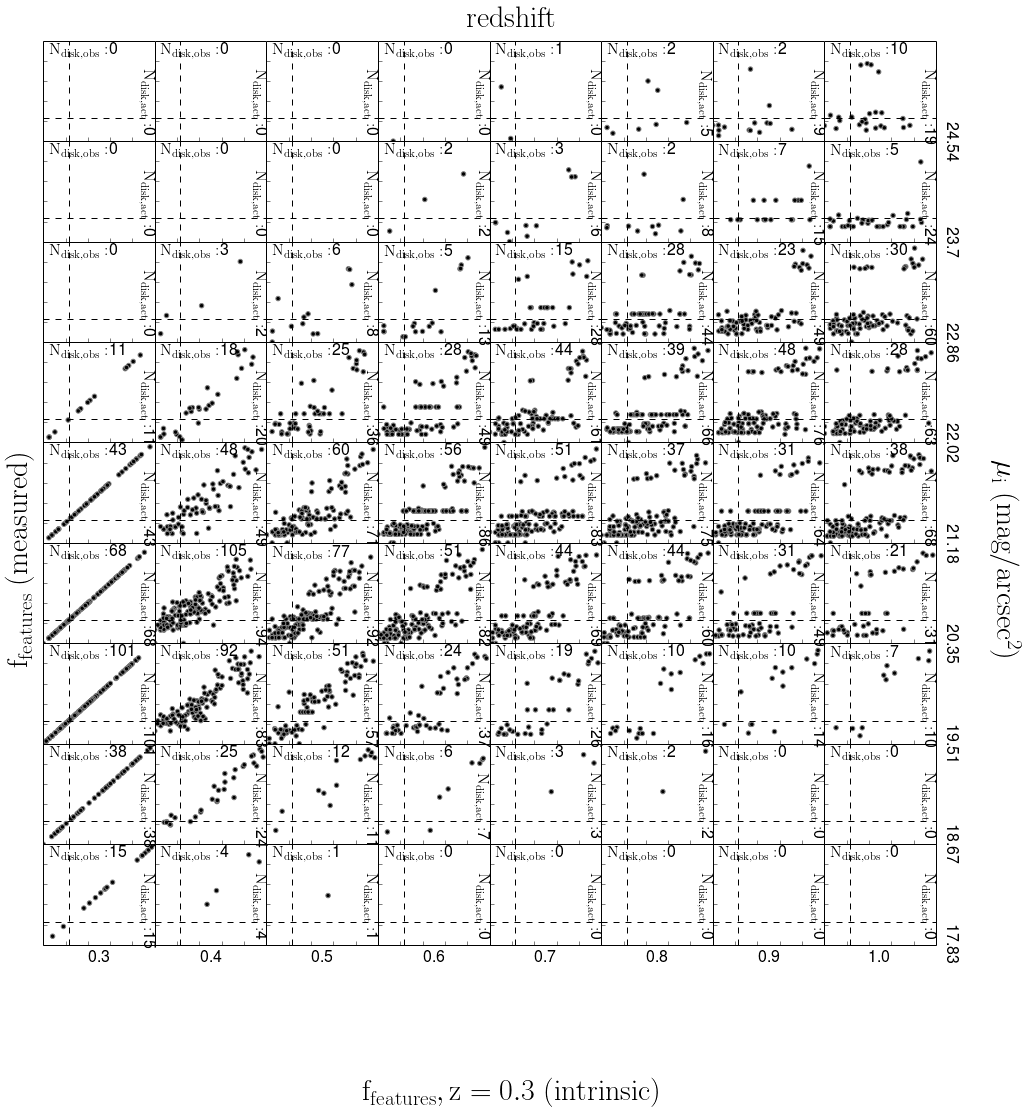

In [65]:
#plot 
f=figure(figsize=(20,18))
x_new = np.linspace(0,.95,40)

disk_cut = .23
completion_matrix = np.zeros(shape=(len(xedges)-1,len(yedges)-1))

gs=gridspec.GridSpec(len(yedges),len(xedges)+1)
gs.update(wspace=0)
gs.update(hspace=0)
yedge_int=np.linspace(0,len(yedges)-2,len(yedges)-1)
yedge_int=[int(y) for y in yedge_int]
yedge_int=yedge_int[::-1]
y_label=[]
x_label=[]
facecolors=['#af8dc3','#999999','#7fbf7b']
for i in range(0,len(yedges)-1):
    y_label.append(round((yedges[i]+yedges[i+1])/2,2))
y_label=y_label[::-1]
for i in range(0,len(xedges)-1):
    x_label.append(round((xedges[i]+xedges[i+1])/2,2))

for y in range(0,len(yedges)-1):
    for x in range(0,len(xedges)-1):
        ax=plt.subplot(gs[yedge_int[y],x])
        xs=scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'lo']
        ys=scatter_dct[xedges[x],xedges[x+1],yedges[y],yedges[y+1],'hi']

        plt.axhline(disk_cut,ls='dashed',c='k')
        plt.axvline(disk_cut,ls='dashed',c='k')
        #calculate number of observed disks
        disks_observed = sum(i>=disk_cut for i in ys) 
        disks_actual = sum(i>=disk_cut for i in xs)

        completion_matrix.T[y,x]=(float(disks_observed)/disks_actual) if len(xs)>10 and disks_actual > 0 else 'nan'

        
        ax.text(.05,.85,'$\mathrm{N_{disk,obs}:}$%s'%disks_observed,fontsize=16)
        ax.text(.85,.6,'$\mathrm{N_{disk,act}:}$%s'%disks_actual,rotation=270,fontsize=16)

        plt.scatter(xs,ys,c='k',edgecolors='gray')

        plt.tick_params(labelleft='off')
        plt.tick_params(top='off',right='off',labelbottom='off')
        plt.xlim(0,1)
        plt.ylim(0,1)
        if y==0:
            plt.xlabel('%s'%str(x_label[x]),fontsize=16)

        if x==7:
            ax.yaxis.set_label_position("right")
            plt.ylabel('%s'%str(yedges[y]),fontsize=16,rotation=270)
            ax.yaxis.set_label_coords(1.2, 0)
    


f.text(.78,.5,r'$\mathrm{\mu_{i}~(mag/arcsec^2)}$',rotation=270,fontsize=30,va='center')
f.text(.45,.91,r'$\mathrm{redshift}$',fontsize=30,ha='center')
f.text(.1,.5,r'$\mathrm{f_{features}~(measured)}$',rotation=90,fontsize=30,va='center')
f.text(.45,.08,r'$\mathrm{f_{features},z=0.3~(intrinsic)}$',fontsize=30,ha='center')

#plt.savefig('Images/red_ferengi_corrected_debiased.png')

In [69]:
completion_matrix[1]

array([        nan,  1.04166667,  1.10843373,  1.11702128,  0.97959184,
        0.9       ,         nan,         nan,         nan])

In [71]:
z = np.linspace(0,len(completion_matrix[1]),len(completion_matrix[1]+1))

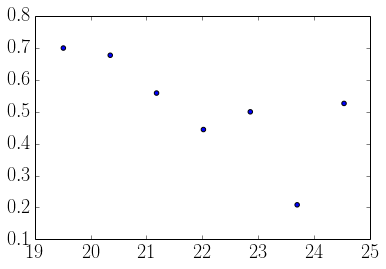

In [88]:
plt.scatter(yedges[0:9],completion_matrix[7])

In [77]:
mnuv: .23 um
r: .623 um
j: 1.2 um
    
sloan:
u: .354
r: .622
z: .905

9

(0, 3)

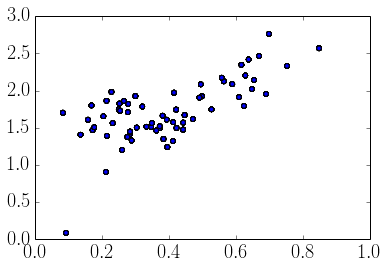

In [96]:
plt.scatter(data['r']-data['z'],data['u']-data['r'])
plt.xlim(0,1)
plt.ylim(0,3)

In [92]:
ur = [row['u']-row['r'] for row in data]

TypeError: unsupported operand type(s) for -: 'numpy.string_' and 'numpy.string_'

In [93]:
data['u'][0]

'16.53541 '